In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np

import pymudokon as pm

In [2]:
def create_circle(center: np.array, radius: float, cell_size: float, ppc: int = 2):
    """Generate a circle of particles.

    Args:
        center (np.array): center of the circle
        radius (float): radius of the circle
        cell_size (float): size of the background grid cells
        ppc (int, optional): particles per cell. Defaults to 2.

    Returns:
        np.array: coordinates of the particles
    """
    start, end = center - radius, center + radius
    spacing = cell_size / (ppc / 2)
    tol = +0.00005  # Add a tolerance to avoid numerical issues
    x = np.arange(start[0], end[0] + spacing, spacing) + 0.5 * spacing
    y = np.arange(start[1], end[1] + spacing, spacing) + 0.5 * spacing
    xv, yv = np.meshgrid(x, y)
    grid_coords = np.array(list(zip(xv.flatten(), yv.flatten()))).astype(np.float64)
    circle_mask = (grid_coords[:, 0] - center[0]) ** 2 + (grid_coords[:, 1] - center[1]) ** 2 < radius**2 + tol
    return grid_coords[circle_mask]

In [3]:
# Create circles of particles and concatenate them into a single array

circle1_center = np.array([0.255, 0.255])
circle2_center = np.array([0.745, 0.745])
circle_radius = 0.2

circle_centers = np.array([circle1_center, circle2_center])
cell_size = 0.05
particles_per_cell = 4


circles = [create_circle(center, circle_radius, cell_size, particles_per_cell) for center in circle_centers]
pos = np.vstack(circles)


velocities = [np.full(circle.shape, 0.1 if i == 0 else -0.1) for i, circle in enumerate(circles)]
vels = np.vstack(velocities)

In [4]:
particles = pm.Particles.register(positions=jnp.array(pos), velocities=jnp.array(vels), original_density=1000)
particles = particles.calculate_volume(cell_size, particles_per_cell=4)
particles = particles.replace(masses=1000 * particles.volumes)
nodes = pm.Nodes.register(
    origin=jnp.array([0.0, 0.0]), end=jnp.array([1.0, 1.0]), node_spacing=cell_size, particles_per_cell=4
)

material = pm.LinearIsotropicElastic.register(E=1000.0, nu=0.3, num_particles=len(pos), dim=2)

# shapefunctions = pm.LinearShapeFunction.register(len(pos), 2)
shapefunctions = pm.CubicShapeFunction.register(len(pos), 2)
nodes = shapefunctions.set_nodes_species(nodes)

In [5]:
usl = pm.USL.register(
    particles=particles, nodes=nodes, materials=[material], shapefunctions=shapefunctions, alpha=1.0, dt=0.001
)

In [6]:
pl = pm.plotter_create()

pl, cloud1 = pm.plotter_add_particles(pl, particles)

pl.show()

Widget(value='<iframe src="http://localhost:45591/index.html?ui=P_0x7f5c9012f430_0&reconnect=auto" class="pyvi…

In [7]:
def some_callback(package):
    global pl, cloud1, cloud2,grid
    usl, step = package
    cloud1 = pm.plotter_update_particles(cloud1, usl.particles)
    pl = pm.update_plotter_animation(pl)
    print(f"output {step}", end="\r")


usl = usl.solve(num_steps=3000, output_step=100, output_function=some_callback)
pl.close()

(6656, 1, 1) (6656, 2, 1)


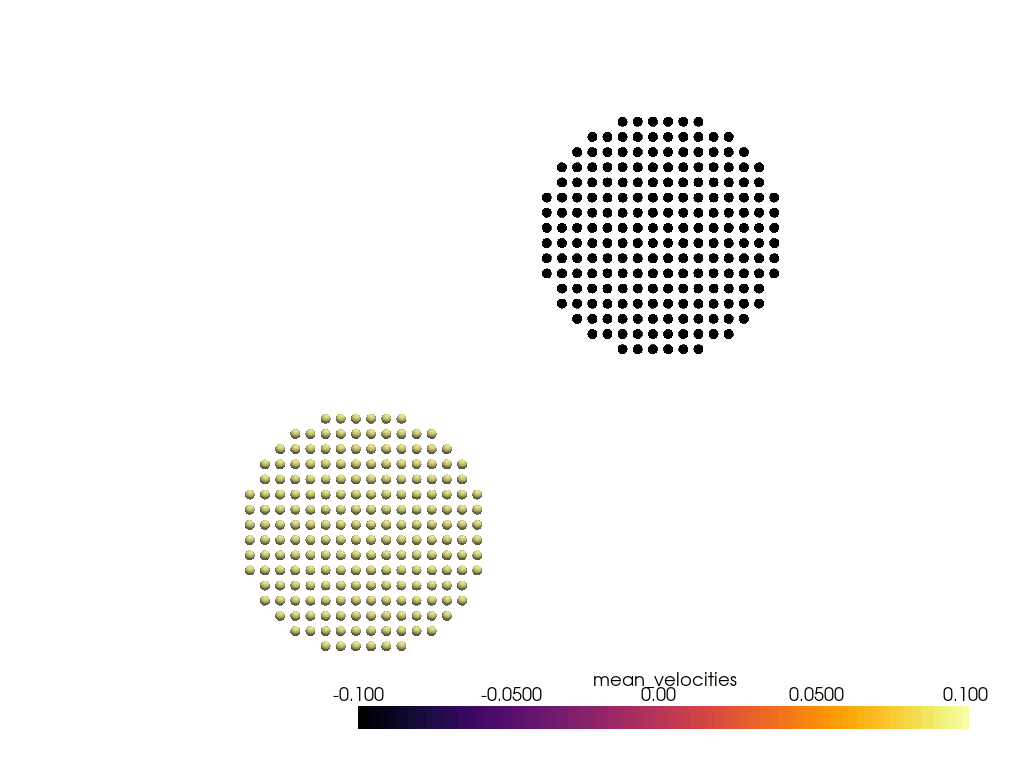

In [8]:
from IPython.display import Image

Image(filename="out.gif")